In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ner-vietnamese/src/LSTM

/content/drive/.shortcut-targets-by-id/1Y4bvRgurskdEet55Gg-Q2Zqg9y7prvJG/ner-vietnamese/src/LSTM


In [ ]:
!pip install swifter

In [4]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [8]:
import utils

In [9]:
data_df = utils.pre_process()

Pandas Apply:   0%|          | 0/1003559 [00:00<?, ?it/s]

In [10]:
data_df

,sentence_id,words,labels
0,0,Đại,B-PERSONTYPE
1,0,diện,I-PERSONTYPE
2,0,VKS,I-PERSONTYPE
3,0,đề,O
4,0,nghị,O
...,...,...,...
985769,45988,đến,O
985770,45988,cựu,B-PERSONTYPE
985771,45988,Chủ,I-PERSONTYPE
985772,45988,tịch,I-PERSONTYPE


In [11]:
# split_index = int(0.8* 45988)
# split_index
# train = data_df[data_df.sentence_id < split_index ]
# dev = data_df[data_df.sentence_id >= split_index ]

In [12]:
agg = lambda s: [(w, t) for w, t in zip(s['words'].values.tolist(),
                                        s['labels'].values.tolist())]
grouped = data_df.groupby("sentence_id").apply(agg)
sentences = [s for s in grouped]

In [13]:

X_train, X_test, y_train, y_test, word2idx, tag2idx, idx2word, idx2tag, num_tag,words, tags  = utils.process_data(data_df, sentences)

In [14]:
# Config
batch_size = 64
epochs = 50
max_len = 75
embedding = 40

In [ ]:
# !pip install git+https://www.github.com/keras-team/keras-contrib.git

In [77]:
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input, load_model
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint

In [17]:
def build_model(num_tags, hidden_size = 50):
    # Model architecture
    input = Input(shape=(max_len,))
    model = Embedding(input_dim=len(words) + 2, output_dim=embedding, input_length=max_len, mask_zero=False)(input)
    model = Bidirectional(LSTM(units=hidden_size, return_sequences=True, recurrent_dropout=0.1))(model)
    model = TimeDistributed(Dense(hidden_size, activation="relu"))(model)
    crf = CRF(num_tags + 1)  # CRF layer
    out = crf(model)  # output

    model = Model(input, out)
    model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

    model.summary()
    return model

In [78]:
build_model(num_tag)

/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 75, 40)            809520    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 75, 100)           36400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_2 (CRF)                  (None, 75, 88)            12408     
Total params: 863,378
Trainable params: 863,378
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import os 
import numpy as np
if not os.path.exists("/content/model.hdf5"):
    model = build_model(num_tag)
    checkpoint = ModelCheckpoint(filepath = '/content/model.hdf5',
                           verbose = 0,
                           mode = 'auto',
                           save_best_only = True,
                           monitor='val_loss')
    history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=epochs,
                        validation_split=0.1, callbacks=[checkpoint])
else:
    model = build_model(num_tag)
    model.load_weights("/content/model.hdf5")

In [35]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [43]:
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true]

In [72]:
flat_true =[]
flat_pred =[]
for sent in y_test_true:
  for x in sent:
    flat_true.append(x)

for sent in y_pred:
  for x in sent:
    flat_pred.append(x)

370725
370725


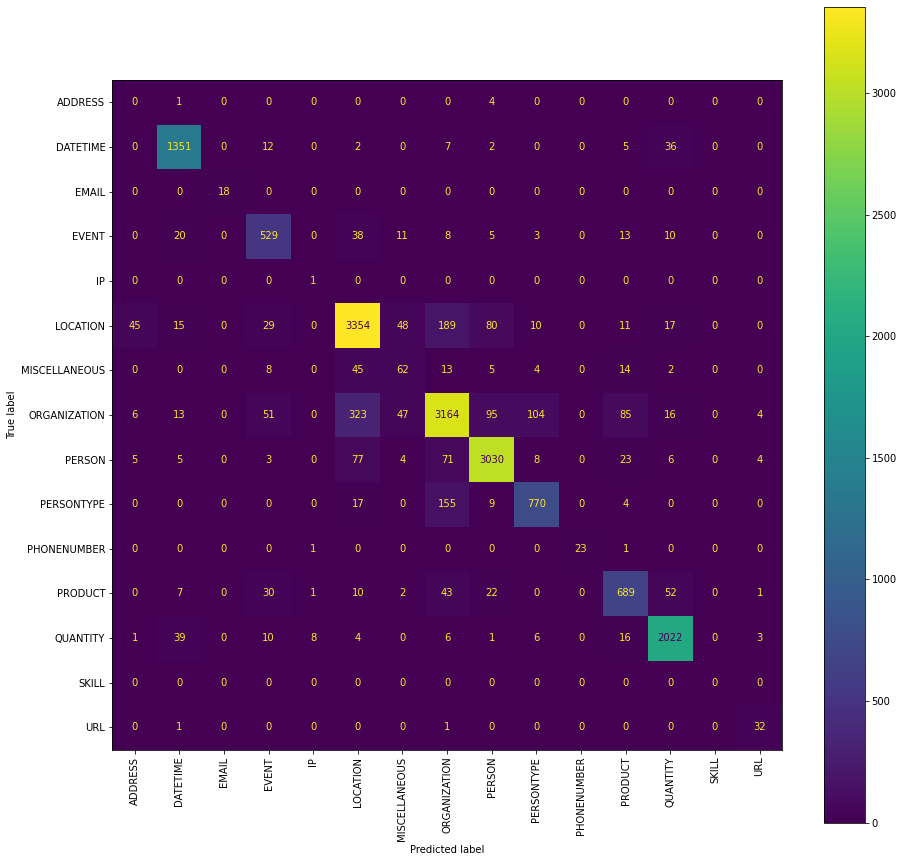

In [46]:
labels= ['B-PERSONTYPE',
  'B-PERSON',
  'B-ORGANIZATION',
  'B-LOCATION-GPE',
  'B-LOCATION',
  'B-DATETIME',
  'B-QUANTITY',
  'B-DATETIME-DATE',
  'B-PRODUCT',
  'B-QUANTITY-AGE',
  'B-DATETIME-SET',
  'B-QUANTITY-NUM',
  'B-MISCELLANEOUS',
  'B-QUANTITY-PER',
  'B-DATETIME-TIMERANGE',
  'B-EVENT-CUL',
  'B-QUANTITY-CUR',
  'B-ORGANIZATION-STOCK',
  'B-DATETIME-TIME',
  'B-LOCATION-STRUC',
  'B-ADDRESS',
  'B-QUANTITY-ORD',
  'B-DATETIME-DURATION',
  'B-LOCATION-GEO',
  'B-EVENT',
  'B-SKILL',
  'B-URL',
  'B-QUANTITY-DIM',
  'B-EVENT-SPORT',
  'B-PRODUCT-LEGAL',
  'B-ORGANIZATION-SPORTS',
  'B-DATETIME-DATERANGE',
  'B-QUANTITY-TEM',
  'B-ORGANIZATION-MED',
  'B-EVENT-GAMESHOW',
  'B-EMAIL',
  'B-PHONENUMBER',
  'B-PRODUCT-COM',
  'B-IP',
  'B-EVENT-NATURAL',
  'B-PRODUCT-AWARD']

flat_true_coff = []
flat_preds_coff = []

for sent in y_test_true:
  for x in sent:
    if '-' in x:
        x = x.split('-')[1]
    flat_true_coff.append(x) 

for sent in y_pred:
  for x in sent:
    if '-' in x:
        x = x.split('-')[1]
    flat_preds_coff.append(x) 

print(len(flat_preds_coff))
print(len(flat_true_coff))

label_rm_begin = []
for x in labels:
    if '-' in x:
        x = x.split('-')[1]
    label_rm_begin.append(x)



label_rm_begin = list(set(label_rm_begin))

label_rm_begin.sort()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


cm = confusion_matrix(flat_preds_coff, flat_true_coff, labels=label_rm_begin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_rm_begin)
fig, ax = plt.subplots(figsize=(15,15))

disp.plot(ax=ax)
plt.xticks(rotation = 90)
plt.show()  

In [ ]:
! pip install git+https://github.com/MeMartijn/updated-sklearn-crfsuite.git#egg=sklearn_crfsuite

In [ ]:
# !pip install sklearn-crfsuite

In [63]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers,CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import metrics

In [64]:
len(y_pred)

4943

In [65]:
metrics.flat_f1_score(y_test_true, y_pred,
                      average='weighted', labels=labels)

0.6159412578833381

In [68]:
import sklearn

In [74]:
labels.sort()

In [75]:
print(sklearn.metrics.classification_report(
    flat_true, flat_pred, labels=labels, digits=3
))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

            B-ADDRESS      0.000     0.000     0.000         8
           B-DATETIME      0.580     0.538     0.558       385
      B-DATETIME-DATE      0.467     0.412     0.437       187
 B-DATETIME-DATERANGE      0.222     0.049     0.080        41
  B-DATETIME-DURATION      0.660     0.779     0.715       172
       B-DATETIME-SET      0.000     0.000     0.000         9
      B-DATETIME-TIME      0.500     0.341     0.406        41
 B-DATETIME-TIMERANGE      0.269     0.163     0.203        43
              B-EMAIL      1.000     1.000     1.000         6
              B-EVENT      0.469     0.227     0.306        66
          B-EVENT-CUL      0.519     0.452     0.483        31
     B-EVENT-GAMESHOW      0.469     0.288     0.357        52
      B-EVENT-NATURAL      0.857     0.800     0.828        15
        B-EVENT-SPORT      0.688     0.646     0.667        82
                 B-IP      1.000     0.125     0.222  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
